# ชื่อโครงงาน : BBC News category Predict

<h2>รายชื่อสมาชิก</h2>

<h3>1. ศุภกร ทวีชัยนฤมิตร   รหัสนิสิต 61102010164</h3> 
<h3>2. ณัฐิวุฒิ เอกธาราวงศ์  รหัสนิสิต 61102010423</h3>

BBC News
https://medium.com/analytics-vidhya/bbc-news-text-classification-a1b2a61af903 <br>
https://github.com/cigdemtuncer/NewsTextClassification



#Data PreProcessing

##Import Library

In [ ]:
# Standard Libraries
import pandas as pd
import numpy as np
import json

# Data Preprocessing & NLP
import nltk
import re
import string
import gensim
from textblob import Word

import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize

from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier, BaggingRegressor, GradientBoostingClassifier,BaggingClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics.pairwise import linear_kernel

# Performance metrics
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, make_scorer, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics.pairwise import cosine_similarity

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
news_df = pd.read_csv('bbc-text.csv')

In [ ]:
news_df.head(10)

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
5,politics,howard hits back at mongrel jibe michael howar...
6,politics,blair prepares to name poll date tony blair is...
7,sport,henman hopes ended in dubai third seed tim hen...
8,sport,wilkinson fit to face edinburgh england captai...
9,entertainment,last star wars not for children the sixth an...


In [ ]:
news_df.shape

(2225, 2)

In [ ]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [ ]:
news_df.columns

Index(['category', 'text'], dtype='object')

In [ ]:
# นับจำนวนแต่ประเภทของข่าว
news_df['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

#Part 1 Clean Data

##Overview

In [ ]:
news_df_final = news_df
news_df_final

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...


In [ ]:
# สร้าง category_id ด้วย index number
news_df_final['category_id'] = news_df_final['category'].factorize()[0]
news_df_final

,category,text,category_id
0,tech,tv future in the hands of viewers with home th...,0
1,business,worldcom boss left books alone former worldc...,1
2,sport,tigers wary of farrell gamble leicester say ...,2
3,sport,yeading face newcastle in fa cup premiership s...,2
4,entertainment,ocean s twelve raids box office ocean s twelve...,3
...,...,...,...
2220,business,cars pull down us retail figures us retail sal...,1
2221,politics,kilroy unveils immigration policy ex-chatshow ...,4
2222,entertainment,rem announce new glasgow concert us band rem h...,3
2223,politics,how political squabbles snowball it s become c...,4


In [ ]:
# Create a new pandas dataframe "category_id_df", which only has unique Categories, also sorting this list in order of category_id values
category_id_df = news_df_final[['category', 'category_id']].drop_duplicates().sort_values('category_id')
# อันล่างจะแสดง category ที่้ซํ้า
# category_id_df = news_df[['category', 'category_id']]

In [ ]:
# Create a dictionary ( python datastructure - like a lookup table) that 
# can easily convert category names into category_ids and vice-versa
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)

In [ ]:
id_to_category

{0: 'tech', 1: 'business', 2: 'sport', 3: 'entertainment', 4: 'politics'}

In [ ]:
# มีทั้งหมด 5 ประเภท
category_id_df

,category,category_id
0,tech,0
1,business,1
2,sport,2
4,entertainment,3
5,politics,4


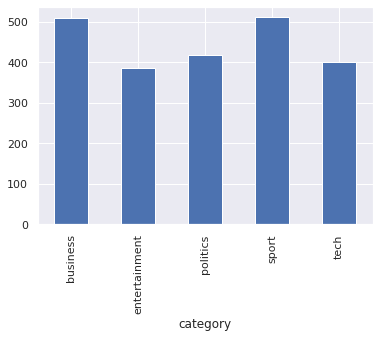

In [ ]:
#Plot the distribution of news articles by category
news_df_final.groupby('category').category_id.count().plot.bar(ylim=0)

##Drop ข้อมูลที่ซํ้ากัน

In [ ]:
# # drop ข้อมูลที่ซํ้ากัน เหลือ 2126 rows
# # After removing duplicated data, my dataset’s row count went down to 2126.
news_df_final.drop_duplicates(subset=['category', 'text'], inplace=True)

In [ ]:
news_df_final.shape

(2126, 3)

##Clean text

In [ ]:
# Data Cleaning
stop_words = set(stopwords.words('english'))
new_stopwords = ['got','get','knew','know','like','cause','oh','said','mr','us','would','could','also','year','people','one','government','new','last','uk','two']
new_stopwords_list = stop_words.union(new_stopwords)
def clean_text(text):
    # remove everything except alphabets
    text = re.sub("[^a-zA-Z]", " ", text)
    # text = re.sub('https?://[A-Za-z0-9./]+','', text)
    # text= re.sub("(@[\w]+)", " ",  text)
    # text= re.sub("(#[\w]+)", " ",  text)
    text = re.sub("[.,!?:;-=^)_%&*+/]+", " ",  text)
    # text= re.sub('[\W]+'," ", text)
    # text= re.sub('[\n]+'," ", text)
    # remove whitespaces
    text = " ".join(i for i in text.split() if not i in new_stopwords_list)
    text = ' '.join(text.split())
    text = text.lower()
    
    return text

In [ ]:
# # Data Cleaning
# stop_words = set(stopwords.words('english'))
# new_stopwords = []
# new_stopwords_list = stop_words.union(new_stopwords)
# def clean_text(text):
#     # remove everything except alphabets
#     text = re.sub("[^a-zA-Z]", " ", text)
#     # text = re.sub('https?://[A-Za-z0-9./]+','', text)
#     # text= re.sub("(@[\w]+)", " ",  text)
#     # text= re.sub("(#[\w]+)", " ",  text)
#     text = re.sub("[.,!?:;-=^)_%&*+/]+", " ",  text)
#     # text= re.sub('[\W]+'," ", text)
#     # text= re.sub('[\n]+'," ", text)
#     # remove whitespaces
#     text = " ".join(i for i in text.split() if not i in new_stopwords_list)
#     text = ' '.join(text.split())
#     text = text.lower()
    
#     return text

In [ ]:
# creating clean text feature
news_df_final['clean_text'] = news_df_final['text'].apply(clean_text).str.replace('bn bn ', '')

# creating clean text feature
news_df_final['clean_text'] = news_df_final['text'].apply(clean_text).str.replace(' bn ', '')

In [ ]:
news_df_final.head(5)

,category,text,category_id,clean_text
0,tech,tv future in the hands of viewers with home th...,0,tv future hands viewers home theatre systems p...
1,business,worldcom boss left books alone former worldc...,1,worldcom boss left books alone former worldcom...
2,sport,tigers wary of farrell gamble leicester say ...,2,tigers wary farrell gamble leicester say rushe...
3,sport,yeading face newcastle in fa cup premiership s...,2,yeading face newcastle fa cup premiership side...
4,entertainment,ocean s twelve raids box office ocean s twelve...,3,ocean twelve raids box office ocean twelve cri...


In [ ]:
news_df_final.shape

(2126, 4)

##Remove Stopwords

In [ ]:
# show the most frequently word
# stopwords-to compare text data with and without stopwords
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 55.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    
    freq_dist = nltk.FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(freq_dist.keys()), 'count':list(freq_dist.values())})
    
    fig = plt.figure(figsize=(21,16))
    ax1 = fig.add_subplot(2,1,1)
    wordcloud = WordCloud(width=1000, height=300, background_color='black', 
                          max_words=1628, relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False).generate_from_frequencies(freq_dist)
    
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    
    # select top 20 most frequent word
    ax2 = fig.add_subplot(2,1,2)
    d = words_df.nlargest(columns="count", n = terms) 
    ax2 = sns.barplot(data=d, palette = sns.color_palette('BuGn_r'), x= "count", y = "word")
    ax2.set(ylabel= 'Word')
    plt.show()


In [ ]:
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)
  
news_df_final['clean_text'] = news_df_final['clean_text'].apply(lambda x: remove_stopwords(x))

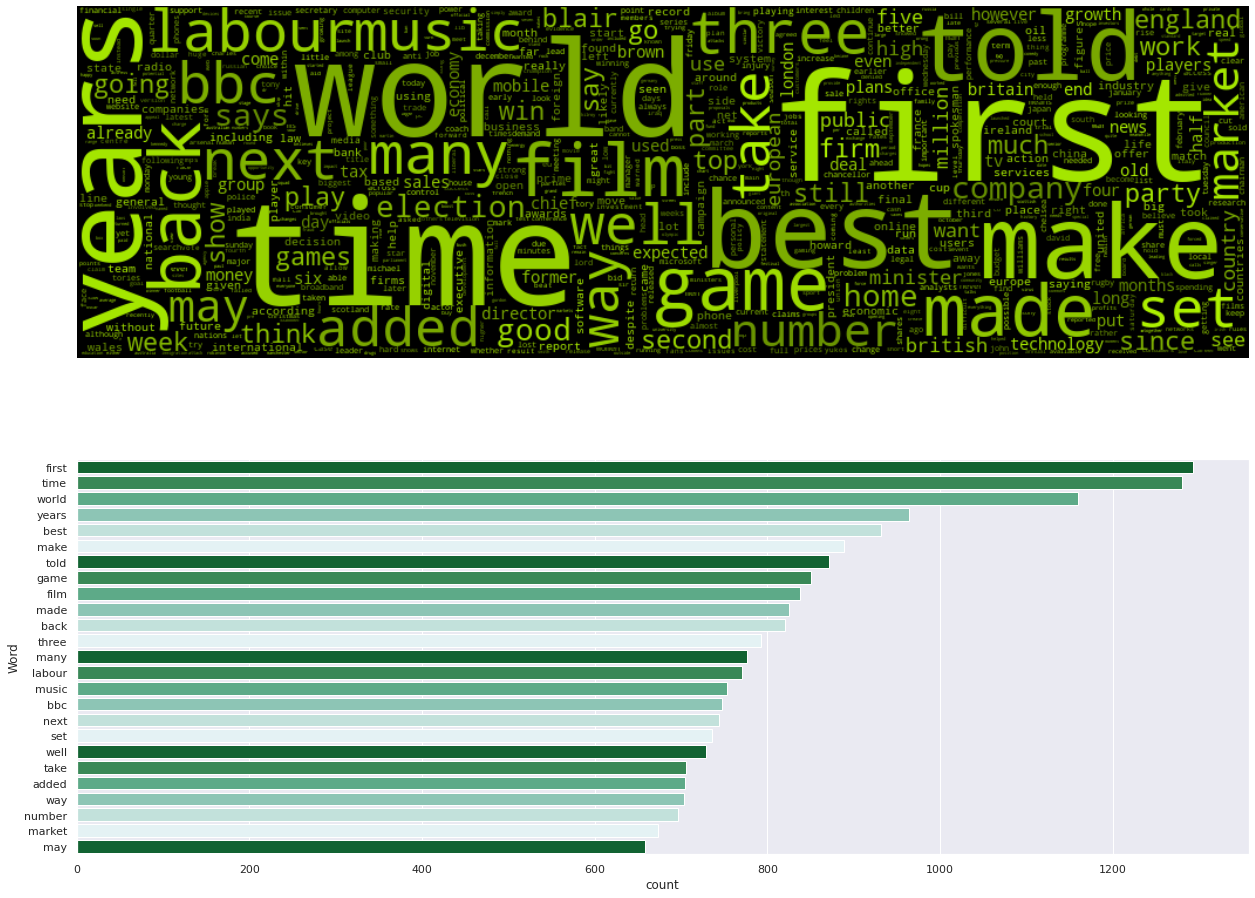

In [ ]:
# plot 25 most frequent words without stopwords **ไม่มีมี stopword
freq_words(news_df_final['clean_text'], 25)

##Lemmatization 

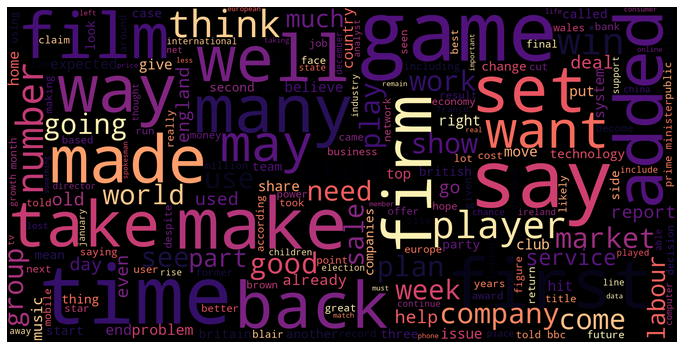

In [ ]:
# Lemmatization 
text = " ".join(review for review in news_df_final.clean_text)
wordcloud = WordCloud(width=1600, height=800,max_font_size=200, colormap='magma').generate(text)

plt.figure(figsize = (12, 10))
plt.imshow(wordcloud, interpolation='spline36')
plt.axis("off")
plt.show()

In [ ]:
wordcloud.to_file("wordcloud.png")

In [ ]:
news_df_final

,category,text,category_id,clean_text
0,tech,tv future in the hands of viewers with home th...,0,tv future hands viewers home theatre systems p...
1,business,worldcom boss left books alone former worldc...,1,worldcom boss left books alone former worldcom...
2,sport,tigers wary of farrell gamble leicester say ...,2,tigers wary farrell gamble leicester say rushe...
3,sport,yeading face newcastle in fa cup premiership s...,2,yeading face newcastle fa cup premiership side...
4,entertainment,ocean s twelve raids box office ocean s twelve...,3,ocean twelve raids box office ocean twelve cri...
...,...,...,...,...
2220,business,cars pull down us retail figures us retail sal...,1,cars pull retail figures retail sales fell jan...
2221,politics,kilroy unveils immigration policy ex-chatshow ...,4,kilroy unveils immigration policy ex chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...,3,rem announce glasgow concert band rem announce...
2223,politics,how political squabbles snowball it s become c...,4,political squabbles snowball become commonplac...


In [ ]:
# Lemmatization process
'''
Words in the third person are changed to first person and verbs in past and future tenses are changed into the present by the 
lemmatization process. 
'''
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    # tokenization to ensure that punctuation is caught as its own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    lem = [lemmatizer.lemmatize(t) for t in filtered_tokens]
    return lem

In [ ]:
news_df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2126 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   category     2126 non-null   object
 1   text         2126 non-null   object
 2   category_id  2126 non-null   int64 
 3   clean_text   2126 non-null   object
dtypes: int64(1), object(3)
memory usage: 83.0+ KB


In [ ]:
news_df_final.shape

(2126, 4)

In [ ]:
news_df_final['tokens'] = [ word_tokenize(x) for x in news_df_final['clean_text']]
news_df_final

,category,text,category_id,clean_text,tokens
0,tech,tv future in the hands of viewers with home th...,0,tv future hands viewers home theatre systems p...,"[tv, future, hands, viewers, home, theatre, sy..."
1,business,worldcom boss left books alone former worldc...,1,worldcom boss left books alone former worldcom...,"[worldcom, boss, left, books, alone, former, w..."
2,sport,tigers wary of farrell gamble leicester say ...,2,tigers wary farrell gamble leicester say rushe...,"[tigers, wary, farrell, gamble, leicester, say..."
3,sport,yeading face newcastle in fa cup premiership s...,2,yeading face newcastle fa cup premiership side...,"[yeading, face, newcastle, fa, cup, premiershi..."
4,entertainment,ocean s twelve raids box office ocean s twelve...,3,ocean twelve raids box office ocean twelve cri...,"[ocean, twelve, raids, box, office, ocean, twe..."
...,...,...,...,...,...
2220,business,cars pull down us retail figures us retail sal...,1,cars pull retail figures retail sales fell jan...,"[cars, pull, retail, figures, retail, sales, f..."
2221,politics,kilroy unveils immigration policy ex-chatshow ...,4,kilroy unveils immigration policy ex chatshow ...,"[kilroy, unveils, immigration, policy, ex, cha..."
2222,entertainment,rem announce new glasgow concert us band rem h...,3,rem announce glasgow concert band rem announce...,"[rem, announce, glasgow, concert, band, rem, a..."
2223,politics,how political squabbles snowball it s become c...,4,political squabbles snowball become commonplac...,"[political, squabbles, snowball, become, commo..."


In [ ]:
len(news_df_final['tokens'])

2126

#Part 2 EDA processing


##Pre Processing

In [ ]:
# Defining a Count Vectorizer object
count_vec = CountVectorizer(stop_words='english', max_features=10000)
# Defining a TF-IDF Vectorizer
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), tokenizer=tokenize_and_lemmatize, max_features=10000, use_idf=True)

features = tfidf_vec.fit_transform(news_df_final.clean_text).toarray() # Remaps the words in the 2225 articles in the text column of 
                                                  # data frame into features (superset of words) with an importance assigned 
                                                  # based on each words frequency in the document and across documents

labels = news_df_final.category_id   

In [ ]:
features.shape # How many features are there ?

(2126, 10000)

In [ ]:
features.itemsize

8

In [ ]:
# The sorted function Converts dictionary items into a (sorted) list. 
# In subsequent steps - We will use this list to iterate over the categories
sorted(category_to_id.items())

[('business', 1),
 ('entertainment', 3),
 ('politics', 4),
 ('sport', 2),
 ('tech', 0)]

In [ ]:
# Create a new pandas dataframe "category_id_df",unique category
category_id_df = news_df_final[['category', 'category_id']].drop_duplicates().sort_values('category_id')

In [ ]:
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)

In [ ]:
id_to_category

{0: 'tech', 1: 'business', 2: 'sport', 3: 'entertainment', 4: 'politics'}

In [ ]:
category_id_df

,category,category_id
0,tech,0
1,business,1
2,sport,2
4,entertainment,3
5,politics,4


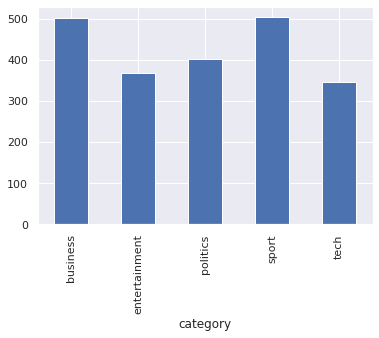

In [ ]:
#plot จำนวนของแต่ละประเภท 
news_df_final.groupby('category').category_id.count().plot.bar(ylim=0)

##Chi-square analysis (Find Correlation Labels to Features)

In [ ]:
# Use chi-square analysis to find corelation between features (importantce of words) and labels(news category) 
from sklearn.feature_selection import chi2

N = 5  # We are going to look for top 3 categories

#For each category, find words that are highly corelated to it
for category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)                   # Do chi2 analyses of all items in this category
    indices = np.argsort(features_chi2[0])                                  # Sorts the indices of features_chi2[0] - the chi-squared stats of each feature
    feature_names = np.array(tfidf_vec.get_feature_names())[indices]            # Converts indices to feature names ( in increasing order of chi-squared stat values)
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]         # List of single word features ( in increasing order of chi-squared stat values)
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]          # List for two-word features ( in increasing order of chi-squared stat values)
    print("# '{}':".format(category))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:]))) # Print 3 unigrams with highest Chi squared stat
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:]))) # Print 3 bigrams with highest Chi squared stat

# 'business':
  . Most correlated unigrams:
       . price
       . economy
       . growth
       . oil
       . bank
  . Most correlated bigrams:
       . consumer spending
       . deutsche boerse
       . oil price
       . stock market
       . economic growth
# 'entertainment':
  . Most correlated unigrams:
       . actor
       . band
       . oscar
       . award
       . film
  . Most correlated bigrams:
       . dollar baby
       . named best
       . los angeles
       . film festival
       . box office
# 'politics':
  . Most correlated unigrams:
       . tory
       . party
       . blair
       . election
       . labour
  . Most correlated bigrams:
       . michael howard
       . liberal democrat
       . general election
       . tony blair
       . prime minister
# 'sport':
  . Most correlated unigrams:
       . england
       . injury
       . champion
       . cup
       . match
  . Most correlated bigrams:
       . davis cup
       . world cup
       . champion le

##Analysis the most frequence of category

In [ ]:
count_category = news_df_final.category.str.split(expand=True).stack().value_counts().reset_index()
count_category.columns = ['Word', 'Frequency'] 
count_category

,Word,Frequency
0,sport,504
1,business,503
2,politics,403
3,entertainment,369
4,tech,347


In [ ]:
category = []
for word in count_category['Word']:
  category.append(word)
  if len(category) == 10:
    break

count_sum_category = []
for word in count_category['Frequency']:
  count_sum_category.append(word)
  if len(count_sum_category) == 10:
    break

In [ ]:
category

['sport', 'business', 'politics', 'entertainment', 'tech']

In [ ]:
count_sum_category

[504, 503, 403, 369, 347]

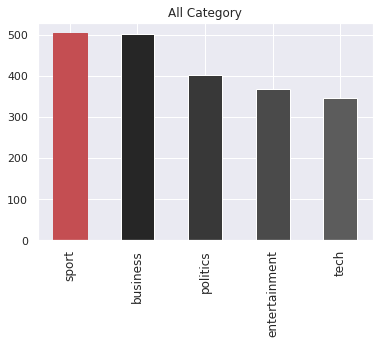

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
labels = category
values = count_sum_category
indexes = np.arange(len(labels))
Color = ['0','0.15','0.22','0.29','0.36','0.43','0.5','0.57','0.64','0.71']

fig, ax = plt.subplots()

bar = ax.bar(labels, values, align="center",width=0.5,color=Color)
bar[0].set_color('r')
plt.xticks(
    rotation=90,
    fontweight='light',
    fontsize='large'  
)
plt.title("All Category")
plt.show()

In [ ]:
news_df_final

,category,text,category_id,clean_text,tokens
0,tech,tv future in the hands of viewers with home th...,0,tv future hands viewers home theatre systems p...,"[tv, future, hands, viewers, home, theatre, sy..."
1,business,worldcom boss left books alone former worldc...,1,worldcom boss left books alone former worldcom...,"[worldcom, boss, left, books, alone, former, w..."
2,sport,tigers wary of farrell gamble leicester say ...,2,tigers wary farrell gamble leicester say rushe...,"[tigers, wary, farrell, gamble, leicester, say..."
3,sport,yeading face newcastle in fa cup premiership s...,2,yeading face newcastle fa cup premiership side...,"[yeading, face, newcastle, fa, cup, premiershi..."
4,entertainment,ocean s twelve raids box office ocean s twelve...,3,ocean twelve raids box office ocean twelve cri...,"[ocean, twelve, raids, box, office, ocean, twe..."
...,...,...,...,...,...
2220,business,cars pull down us retail figures us retail sal...,1,cars pull retail figures retail sales fell jan...,"[cars, pull, retail, figures, retail, sales, f..."
2221,politics,kilroy unveils immigration policy ex-chatshow ...,4,kilroy unveils immigration policy ex chatshow ...,"[kilroy, unveils, immigration, policy, ex, cha..."
2222,entertainment,rem announce new glasgow concert us band rem h...,3,rem announce glasgow concert band rem announce...,"[rem, announce, glasgow, concert, band, rem, a..."
2223,politics,how political squabbles snowball it s become c...,4,political squabbles snowball become commonplac...,"[political, squabbles, snowball, become, commo..."


##Analysis all category

In [ ]:
# EDA 
# -โชว์ graphที่สำคัญในแต่ละ feature
# -โชว์ 10 คำที่มากที่สุุดในแต่ละ category
business_df = news_df_final[news_df_final['category']=='business']
entertainment_df = news_df_final[news_df_final['category']=='entertainment']
politics_df = news_df_final[news_df_final['category']=='politics']
sport_df = news_df_final[news_df_final['category']=='sport']
tech_df = news_df_final[news_df_final['category']=='tech']

In [ ]:
# All category
count_word = news_df_final.category.str.split(expand=True).stack().value_counts().reset_index()
count_word.columns = ['Word', 'Frequency'] 
count_word

,Word,Frequency
0,sport,504
1,business,503
2,politics,403
3,entertainment,369
4,tech,347


In [ ]:
# All category
count_word = news_df_final.clean_text.str.split(expand=True).stack().value_counts().reset_index()
count_word.columns = ['Word', 'Frequency'] 
count_word

,Word,Frequency
0,first,1293
1,time,1280
2,world,1160
3,years,964
4,best,932
...,...,...
28354,cs,1
28355,stringing,1
28356,soybean,1
28357,yield,1


In [ ]:
# Top 10 words of all category
words = []
for word in count_word['Word']:
  words.append(word)
  if len(words) == 10:
    break

count_words = []
for word in count_word['Frequency']:
  count_words.append(word)
  if len(count_words) == 10:
    break


In [ ]:
words

['first',
 'time',
 'world',
 'years',
 'best',
 'make',
 'told',
 'game',
 'film',
 'made']

In [ ]:
count_words 

[1293, 1280, 1160, 964, 932, 889, 872, 851, 838, 825]

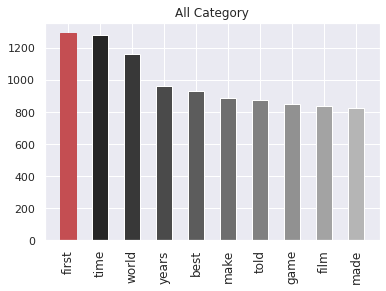

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
labels = words
values = count_words
indexes = np.arange(len(labels))
Color = ['0','0.15','0.22','0.29','0.36','0.43','0.5','0.57','0.64','0.71']

fig, ax = plt.subplots()

bar = ax.bar(labels, values, align="center",width=0.5,color=Color)
bar[0].set_color('r')
plt.xticks(
    rotation=90,
    fontweight='light',
    fontsize='large'  
)
plt.title("All Category")
plt.show()

##Analysis category of business

In [ ]:
count_word_business = business_df.clean_text.str.split(expand=True).stack().value_counts().reset_index()
count_word_business.columns = ['Word', 'Frequency'] 
count_word_business

,Word,Frequency
0,market,426
1,company,406
2,growth,363
3,firm,357
4,economy,342
...,...,...
11338,karya,1
11339,seung,1
11340,nihon,1
11341,amuro,1


In [ ]:
#Top ten Business
words_business = []
for word in count_word_business['Word']:
  words_business.append(word)
  if len(words_business) == 10:
    break
words_business

['market',
 'company',
 'growth',
 'firm',
 'economy',
 'bank',
 'sales',
 'economic',
 'oil',
 'shares']

In [ ]:
count_words_business = []
for word in count_word_business['Frequency']:
  count_words_business.append(word)
  if len(count_words_business) == 10:
    break
count_words_business

[426, 406, 363, 357, 342, 330, 308, 302, 291, 262]

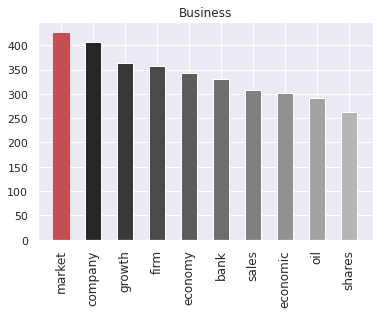

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
labels = words_business
values = count_words_business
indexes = np.arange(len(labels))
Color = ['0','0.15','0.22','0.29','0.36','0.43','0.5','0.57','0.64','0.71']

fig, ax = plt.subplots()

bar = ax.bar(labels, values, align="center",width=0.5,color=Color)
bar[0].set_color('r')
plt.xticks(
    rotation=90,
    fontweight='light',
    fontsize='large'  
)
plt.title("Business")
plt.show()

##Analysis category of entertainment

In [ ]:
count_word_entertainment = entertainment_df.clean_text.str.split(expand=True).stack().value_counts().reset_index()
count_word_entertainment.columns = ['Word', 'Frequency'] 
count_word_entertainment

,Word,Frequency
0,film,746
1,best,589
2,music,423
3,show,320
4,awards,268
...,...,...
11096,brussels,1
11097,filmmaker,1
11098,involves,1
11099,legs,1


In [ ]:
#Top ten Entertain
words_entertainment = []
for word in count_word_entertainment['Word']:
  words_entertainment.append(word)
  if len(words_entertainment) == 10:
    break
words_entertainment

['film',
 'best',
 'music',
 'show',
 'awards',
 'first',
 'award',
 'years',
 'tv',
 'star']

In [ ]:
count_words_entertainment = []
for word in count_word_entertainment['Frequency']:
  count_words_entertainment.append(word)
  if len(count_words_entertainment) == 10:
    break
count_words_entertainment

[746, 589, 423, 320, 268, 243, 239, 222, 210, 206]

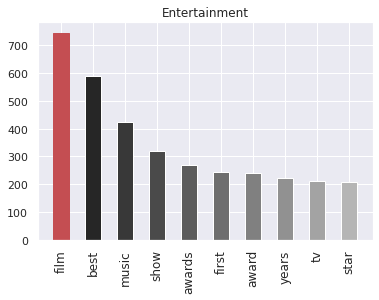

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
labels = words_entertainment
values = count_words_entertainment
indexes = np.arange(len(labels))
Color = ['0','0.15','0.22','0.29','0.36','0.43','0.5','0.57','0.64','0.71']

fig, ax = plt.subplots()

bar = ax.bar(labels, values, align="center",width=0.5,color=Color)
bar[0].set_color('r')
plt.xticks(
    rotation=90,
    fontweight='light',
    fontsize='large'  
)
plt.title("Entertainment")
plt.show()

##Analysis category of politics

In [ ]:
count_word_politics = politics_df.clean_text.str.split(expand=True).stack().value_counts().reset_index()
count_word_politics.columns = ['Word', 'Frequency'] 
count_word_politics

,Word,Frequency
0,labour,735
1,election,575
2,party,561
3,blair,541
4,minister,416
...,...,...
10718,dunstan,1
10719,yellow,1
10720,densities,1
10721,sheltered,1


In [ ]:
#Top ten politics
words_politics = []
for word in count_word_politics['Word']:
  words_politics.append(word)
  if len(words_politics) == 10:
    break
words_politics

['labour',
 'election',
 'party',
 'blair',
 'minister',
 'brown',
 'told',
 'howard',
 'public',
 'plans']

In [ ]:
count_words_politics = []
for word in count_word_politics['Frequency']:
  count_words_politics.append(word)
  if len(count_words_politics) == 10:
    break
count_words_politics

[735, 575, 561, 541, 416, 355, 340, 308, 301, 301]

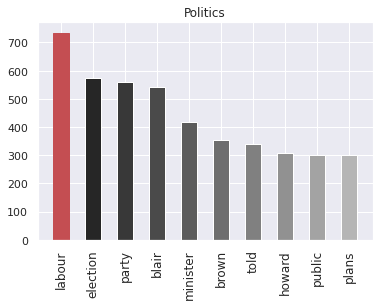

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
labels = words_politics
values = count_words_politics
indexes = np.arange(len(labels))
Color = ['0','0.15','0.22','0.29','0.36','0.43','0.5','0.57','0.64','0.71']

fig, ax = plt.subplots()

bar = ax.bar(labels, values, align="center",width=0.5,color=Color)
bar[0].set_color('r')
plt.xticks(
    rotation=90,
    fontweight='light',
    fontsize='large'  
)
plt.title("Politics")
plt.show()

##Analysis category of sport

In [ ]:
count_word_sport = sport_df.clean_text.str.split(expand=True).stack().value_counts().reset_index()
count_word_sport.columns = ['Word', 'Frequency'] 
count_word_sport

,Word,Frequency
0,first,478
1,game,474
2,england,457
3,time,421
4,win,412
...,...,...
10039,herron,1
10040,outclass,1
10041,shadows,1
10042,avoids,1


In [ ]:
#Top ten sport
words_sport = []
for word in count_word_sport['Word']:
  words_sport.append(word)
  if len(words_sport) == 10:
    break
words_sport

['first',
 'game',
 'england',
 'time',
 'win',
 'world',
 'back',
 'players',
 'team',
 'play']

In [ ]:
count_words_sport = []
for word in count_word_sport['Frequency']:
  count_words_sport.append(word)
  if len(count_words_sport) == 10:
    break
count_words_sport

[478, 474, 457, 421, 412, 383, 372, 305, 300, 295]

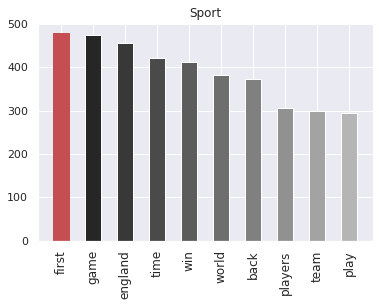

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
labels = words_sport
values = count_words_sport
indexes = np.arange(len(labels))
Color = ['0','0.15','0.22','0.29','0.36','0.43','0.5','0.57','0.64','0.71']

fig, ax = plt.subplots()

bar = ax.bar(labels, values, align="center",width=0.5,color=Color)
bar[0].set_color('r')
plt.xticks(
    rotation=90,
    fontweight='light',
    fontsize='large'  
)
plt.title("Sport")
plt.show()

##Analysis category of tech

In [ ]:
count_word_tech = tech_df.clean_text.str.split(expand=True).stack().value_counts().reset_index()
count_word_tech.columns = ['Word', 'Frequency'] 
count_word_tech

,Word,Frequency
0,technology,450
1,mobile,440
2,games,388
3,users,344
4,use,340
...,...,...
11516,negotiations,1
11517,hilarious,1
11518,paused,1
11519,dorries,1


In [ ]:
#Top ten tech
words_tech = []
for word in count_word_tech['Word']:
  words_tech.append(word)
  if len(words_tech) == 10:
    break
words_tech


['technology',
 'mobile',
 'games',
 'users',
 'use',
 'net',
 'game',
 'music',
 'many',
 'software']

In [ ]:
count_words_tech = []
for word in count_word_tech['Frequency']:
  count_words_tech.append(word)
  if len(count_words_tech) == 10:
    break
count_words_tech

[450, 440, 388, 344, 340, 321, 317, 314, 310, 299]

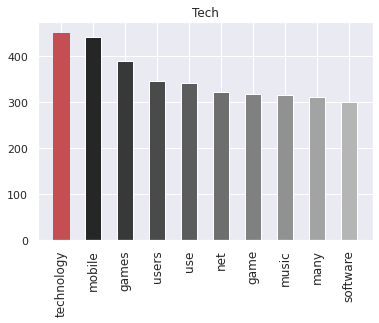

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
labels = words_tech
values = count_words_tech
indexes = np.arange(len(labels))
Color = ['0','0.15','0.22','0.29','0.36','0.43','0.5','0.57','0.64','0.71']

fig, ax = plt.subplots()

bar = ax.bar(labels, values, align="center",width=0.5,color=Color)
bar[0].set_color('r')
plt.xticks(
    rotation=90,
    fontweight='light',
    fontsize='large'  
)
plt.title("Tech")
plt.show()

In [ ]:
# news_df_final.to_csv('out_df.csv', index=False)

In [ ]:
news_df_final.head(5)

,category,text,category_id,clean_text,tokens
0,tech,tv future in the hands of viewers with home th...,0,tv future hands viewers home theatre systems p...,"[tv, future, hands, viewers, home, theatre, sy..."
1,business,worldcom boss left books alone former worldc...,1,worldcom boss left books alone former worldcom...,"[worldcom, boss, left, books, alone, former, w..."
2,sport,tigers wary of farrell gamble leicester say ...,2,tigers wary farrell gamble leicester say rushe...,"[tigers, wary, farrell, gamble, leicester, say..."
3,sport,yeading face newcastle in fa cup premiership s...,2,yeading face newcastle fa cup premiership side...,"[yeading, face, newcastle, fa, cup, premiershi..."
4,entertainment,ocean s twelve raids box office ocean s twelve...,3,ocean twelve raids box office ocean twelve cri...,"[ocean, twelve, raids, box, office, ocean, twe..."


In [ ]:
news_df_final.shape

(2126, 5)

In [ ]:
news_df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2126 entries, 0 to 2224
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   category     2126 non-null   object
 1   text         2126 non-null   object
 2   category_id  2126 non-null   int64 
 3   clean_text   2126 non-null   object
 4   tokens       2126 non-null   object
dtypes: int64(1), object(4)
memory usage: 179.7+ KB


In [ ]:
X = news_df_final.loc[:,'clean_text']
y = news_df_final.loc[:,'category_id']

In [ ]:
X

0       tv future hands viewers home theatre systems p...
1       worldcom boss left books alone former worldcom...
2       tigers wary farrell gamble leicester say rushe...
3       yeading face newcastle fa cup premiership side...
4       ocean twelve raids box office ocean twelve cri...
                              ...                        
2220    cars pull retail figures retail sales fell jan...
2221    kilroy unveils immigration policy ex chatshow ...
2222    rem announce glasgow concert band rem announce...
2223    political squabbles snowball become commonplac...
2224    souness delight euro progress boss graeme soun...
Name: clean_text, Length: 2126, dtype: object

In [ ]:
y

0       0
1       1
2       2
3       2
4       3
       ..
2220    1
2221    4
2222    3
2223    4
2224    2
Name: category_id, Length: 2126, dtype: int64

#Word presetnation (TFIDF)

In [ ]:
news_df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2126 entries, 0 to 2224
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   category     2126 non-null   object
 1   text         2126 non-null   object
 2   category_id  2126 non-null   int64 
 3   clean_text   2126 non-null   object
 4   tokens       2126 non-null   object
dtypes: int64(1), object(4)
memory usage: 179.7+ KB


In [ ]:
news_df_final.head(10)

,category,text,category_id,clean_text,tokens
0,tech,tv future in the hands of viewers with home th...,0,tv future hands viewers home theatre systems p...,"[tv, future, hands, viewers, home, theatre, sy..."
1,business,worldcom boss left books alone former worldc...,1,worldcom boss left books alone former worldcom...,"[worldcom, boss, left, books, alone, former, w..."
2,sport,tigers wary of farrell gamble leicester say ...,2,tigers wary farrell gamble leicester say rushe...,"[tigers, wary, farrell, gamble, leicester, say..."
3,sport,yeading face newcastle in fa cup premiership s...,2,yeading face newcastle fa cup premiership side...,"[yeading, face, newcastle, fa, cup, premiershi..."
4,entertainment,ocean s twelve raids box office ocean s twelve...,3,ocean twelve raids box office ocean twelve cri...,"[ocean, twelve, raids, box, office, ocean, twe..."
5,politics,howard hits back at mongrel jibe michael howar...,4,howard hits back mongrel jibe michael howard c...,"[howard, hits, back, mongrel, jibe, michael, h..."
6,politics,blair prepares to name poll date tony blair is...,4,blair prepares name poll date tony blair likel...,"[blair, prepares, name, poll, date, tony, blai..."
7,sport,henman hopes ended in dubai third seed tim hen...,2,henman hopes ended dubai third seed tim henman...,"[henman, hopes, ended, dubai, third, seed, tim..."
8,sport,wilkinson fit to face edinburgh england captai...,2,wilkinson fit face edinburgh england captain j...,"[wilkinson, fit, face, edinburgh, england, cap..."
9,entertainment,last star wars not for children the sixth an...,3,star wars children sixth final star wars movie...,"[star, wars, children, sixth, final, star, war..."


In [ ]:
# from sklearn import preprocessing

# le = preprocessing.LabelEncoder()
# le.fit(["tech", "business","sport", "entertainment",'politics'])

In [ ]:
news_df_final

,category,text,category_id,clean_text,tokens
0,tech,tv future in the hands of viewers with home th...,0,tv future hands viewers home theatre systems p...,"[tv, future, hands, viewers, home, theatre, sy..."
1,business,worldcom boss left books alone former worldc...,1,worldcom boss left books alone former worldcom...,"[worldcom, boss, left, books, alone, former, w..."
2,sport,tigers wary of farrell gamble leicester say ...,2,tigers wary farrell gamble leicester say rushe...,"[tigers, wary, farrell, gamble, leicester, say..."
3,sport,yeading face newcastle in fa cup premiership s...,2,yeading face newcastle fa cup premiership side...,"[yeading, face, newcastle, fa, cup, premiershi..."
4,entertainment,ocean s twelve raids box office ocean s twelve...,3,ocean twelve raids box office ocean twelve cri...,"[ocean, twelve, raids, box, office, ocean, twe..."
...,...,...,...,...,...
2220,business,cars pull down us retail figures us retail sal...,1,cars pull retail figures retail sales fell jan...,"[cars, pull, retail, figures, retail, sales, f..."
2221,politics,kilroy unveils immigration policy ex-chatshow ...,4,kilroy unveils immigration policy ex chatshow ...,"[kilroy, unveils, immigration, policy, ex, cha..."
2222,entertainment,rem announce new glasgow concert us band rem h...,3,rem announce glasgow concert band rem announce...,"[rem, announce, glasgow, concert, band, rem, a..."
2223,politics,how political squabbles snowball it s become c...,4,political squabbles snowball become commonplac...,"[political, squabbles, snowball, become, commo..."


##One Hot Encoder

In [ ]:
news_df_final["labels"] = news_df_final["category"].apply(lambda x: x.replace(",",""))
#tweet_string = re.sub(r'\s+',' ', tweet_string)
#replace white space 
news_df_final["labels"]  = news_df_final["labels"].apply(lambda x: x.split())
news_df_final.head()

,category,text,category_id,clean_text,tokens,labels
0,tech,tv future in the hands of viewers with home th...,0,tv future hands viewers home theatre systems p...,"[tv, future, hands, viewers, home, theatre, sy...",[tech]
1,business,worldcom boss left books alone former worldc...,1,worldcom boss left books alone former worldcom...,"[worldcom, boss, left, books, alone, former, w...",[business]
2,sport,tigers wary of farrell gamble leicester say ...,2,tigers wary farrell gamble leicester say rushe...,"[tigers, wary, farrell, gamble, leicester, say...",[sport]
3,sport,yeading face newcastle in fa cup premiership s...,2,yeading face newcastle fa cup premiership side...,"[yeading, face, newcastle, fa, cup, premiershi...",[sport]
4,entertainment,ocean s twelve raids box office ocean s twelve...,3,ocean twelve raids box office ocean twelve cri...,"[ocean, twelve, raids, box, office, ocean, twe...",[entertainment]


In [ ]:
 news_df_final["labels"]

0                [tech]
1            [business]
2               [sport]
3               [sport]
4       [entertainment]
             ...       
2220         [business]
2221         [politics]
2222    [entertainment]
2223         [politics]
2224            [sport]
Name: labels, Length: 2126, dtype: object

In [ ]:
unique_labels = sum(news_df_final["labels"].tolist(), [])
unique_labels = list(sorted(list(set(unique_labels))))
unique_labels 

['business', 'entertainment', 'politics', 'sport', 'tech']

In [ ]:
news_df_final["y"] = ",".join(unique_labels)
news_df_final["y"] = news_df_final["y"].apply(lambda x: x.split(","))
news_df_final

,category,text,category_id,clean_text,tokens,labels,y
0,tech,tv future in the hands of viewers with home th...,0,tv future hands viewers home theatre systems p...,"[tv, future, hands, viewers, home, theatre, sy...",[tech],"[business, entertainment, politics, sport, tech]"
1,business,worldcom boss left books alone former worldc...,1,worldcom boss left books alone former worldcom...,"[worldcom, boss, left, books, alone, former, w...",[business],"[business, entertainment, politics, sport, tech]"
2,sport,tigers wary of farrell gamble leicester say ...,2,tigers wary farrell gamble leicester say rushe...,"[tigers, wary, farrell, gamble, leicester, say...",[sport],"[business, entertainment, politics, sport, tech]"
3,sport,yeading face newcastle in fa cup premiership s...,2,yeading face newcastle fa cup premiership side...,"[yeading, face, newcastle, fa, cup, premiershi...",[sport],"[business, entertainment, politics, sport, tech]"
4,entertainment,ocean s twelve raids box office ocean s twelve...,3,ocean twelve raids box office ocean twelve cri...,"[ocean, twelve, raids, box, office, ocean, twe...",[entertainment],"[business, entertainment, politics, sport, tech]"
...,...,...,...,...,...,...,...
2220,business,cars pull down us retail figures us retail sal...,1,cars pull retail figures retail sales fell jan...,"[cars, pull, retail, figures, retail, sales, f...",[business],"[business, entertainment, politics, sport, tech]"
2221,politics,kilroy unveils immigration policy ex-chatshow ...,4,kilroy unveils immigration policy ex chatshow ...,"[kilroy, unveils, immigration, policy, ex, cha...",[politics],"[business, entertainment, politics, sport, tech]"
2222,entertainment,rem announce new glasgow concert us band rem h...,3,rem announce glasgow concert band rem announce...,"[rem, announce, glasgow, concert, band, rem, a...",[entertainment],"[business, entertainment, politics, sport, tech]"
2223,politics,how political squabbles snowball it s become c...,4,political squabbles snowball become commonplac...,"[political, squabbles, snowball, become, commo...",[politics],"[business, entertainment, politics, sport, tech]"


In [ ]:
def labelprep(y, labels):
  classes = []
  for gen in y:
    if gen in labels:
      classes.append(1)
    else:
      classes.append(0)
  return classes

news_df_final["classes"] = news_df_final.apply(lambda x: labelprep(x["y"], x["labels"]), axis=1)

In [ ]:
news_df_final_label = news_df_final[['clean_text','labels','category_id']]
news_df_final_label.head()

,clean_text,labels,category_id
0,tv future hands viewers home theatre systems p...,[tech],0
1,worldcom boss left books alone former worldcom...,[business],1
2,tigers wary farrell gamble leicester say rushe...,[sport],2
3,yeading face newcastle fa cup premiership side...,[sport],2
4,ocean twelve raids box office ocean twelve cri...,[entertainment],3


In [ ]:
news_df_final_one = news_df_final[['clean_text','labels','y','classes']]
news_df_final_one.head()

,clean_text,labels,y,classes
0,tv future hands viewers home theatre systems p...,[tech],"[business, entertainment, politics, sport, tech]","[0, 0, 0, 0, 1]"
1,worldcom boss left books alone former worldcom...,[business],"[business, entertainment, politics, sport, tech]","[1, 0, 0, 0, 0]"
2,tigers wary farrell gamble leicester say rushe...,[sport],"[business, entertainment, politics, sport, tech]","[0, 0, 0, 1, 0]"
3,yeading face newcastle fa cup premiership side...,[sport],"[business, entertainment, politics, sport, tech]","[0, 0, 0, 1, 0]"
4,ocean twelve raids box office ocean twelve cri...,[entertainment],"[business, entertainment, politics, sport, tech]","[0, 1, 0, 0, 0]"


##Split Data

In [ ]:
from sklearn.model_selection import train_test_split
X_label = news_df_final_label.loc[:,'clean_text']
y_label = news_df_final_label.loc[:,'category_id']
X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(X_label, y_label, test_size=0.2, stratify=y_label)
# X_train_label, X_test_label, y_train_label, y_test_label, indices_train, indices_test = train_test_split(X_label, y_label, news_df_final_label.index, test_size=0.3, random_state=42)
# X_train_label, X_test_label, y_train_label, y_test_label, indices_train, indices_test = train_test_split(X_label, y_label, news_df.index, test_size=0.2, random_state=55)

In [ ]:
from sklearn.model_selection import train_test_split
X_one = news_df_final_one.loc[:,'clean_text']
y_one = np.array(news_df_final_one["classes"].tolist())
X_train_one, X_test_one, y_train_one, y_test_one = train_test_split(X_one, y_one, test_size=0.2, stratify=y_one)

In [ ]:
# Tf-Idf transformation ห้ามรวม Label กับ One ในช่องเดียว
x_train_label_tfidf = tfidf_vec.fit_transform(X_train_label)
x_test_label_tfidf = tfidf_vec.transform(X_test_label)

In [ ]:
x_train_one_tfidf = tfidf_vec.fit_transform(X_train_one)
x_test_one_tfidf = tfidf_vec.transform(X_test_one)

##TF-IDF

In [ ]:
display_tfidf_train = pd.DataFrame(x_train_label_tfidf.toarray(), columns = tfidf_vec.get_feature_names())
display_tfidf_train

,aaa,aaa title,abandoned,abandoning,abba,abbas,abbasi,abbott,abc,aberdeen,abeyie,abiding,ability,able,able make,able play,able watch,abn,abn amro,abolishing,abortion,abroad,absa,absence,absent,absolute,absolutely,abuse,abused,ac,ac j,ac milan,academic,academy,academy award,accelerating,accept,acceptable,acceptance,accepted,...,year time,yelling,yen,yes,yesterday,yili,yoran,york,york attorney,york marathon,york stock,york time,yorkshire,young,young man,young player,younger,youngest,youngster,youth,yuan,yugansk,yuganskneftegas,yukos,yukos bankruptcy,yukos claim,yushchenko,z,zach,zach braff,zealand,zealand rugby,zero,zhang,zimbabwe,zoe,zombie,zone,zurich,zurich premiership
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.105672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.055614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.025249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.04818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.068991,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.030241,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1696,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039994,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1697,0.0,0.0,0.0,0.0,0.0,0.0,0.136772,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033179,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.015576,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [ ]:
display_tfidf_test = pd.DataFrame(x_test_label_tfidf.toarray(), columns = tfidf_vec.get_feature_names())
display_tfidf_test

,aaa,aaa title,abandoned,abandoning,abba,abbas,abbasi,abbott,abc,aberdeen,abeyie,abiding,ability,able,able make,able play,able watch,abn,abn amro,abolishing,abortion,abroad,absa,absence,absent,absolute,absolutely,abuse,abused,ac,ac j,ac milan,academic,academy,academy award,accelerating,accept,acceptable,acceptance,accepted,...,year time,yelling,yen,yes,yesterday,yili,yoran,york,york attorney,york marathon,york stock,york time,yorkshire,young,young man,young player,younger,youngest,youngster,youth,yuan,yugansk,yuganskneftegas,yukos,yukos bankruptcy,yukos claim,yushchenko,z,zach,zach braff,zealand,zealand rugby,zero,zhang,zimbabwe,zoe,zombie,zone,zurich,zurich premiership
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033454,0.025914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.017770,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029661,0.0,0.0,0.0,0.0,0.047695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.089373,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066466,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.031676,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.021015,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.070152,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
424,0.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
# xtrain_cv = count_vec.fit_transform(X_train)
# xtest_cv = count_vec.transform(X_test)
# xtrain_cv.shape

In [ ]:
# สรุป
print(x_train_label_tfidf.shape)
print(y_train_label.shape)

(1700, 10000)
(1700,)


In [ ]:
print(x_train_one_tfidf.shape)
print(y_train_one.shape)

(1700, 10000)
(1700, 5)


##Model (Label)

In [ ]:
#create list of model and accuracy dicts
perform_list_label = []

In [ ]:
from sklearn.tree import DecisionTreeClassifier
def run_model_label(model_name, est_c, est_pnlty):
    mdl=''
    if model_name == 'Logistic Regression':
        mdl = LogisticRegression()
    elif model_name == 'Random Forest':
        mdl = RandomForestClassifier(n_estimators=100)
    elif model_name == 'Multinomial Naive Bayes':
        mdl = MultinomialNB()
    elif model_name == 'Linear SVC':
        mdl = LinearSVC()
    elif model_name == 'Logistic Regression GridSearchCV':
        mdl = LogisticRegression(C=est_c, penalty=est_pnlty)  

    oneVsRest = OneVsRestClassifier(mdl)
    oneVsRest.fit(x_train_label_tfidf, y_train_label)
    y_pred_label = oneVsRest.predict(x_test_label_tfidf)
    
    
    # Performance metrics
    accuracy = round(accuracy_score(y_test_label, y_pred_label) * 100, 2)
    # Get precision, recall, f1 scores
    precision, recall, f1score, support = score(y_test_label, y_pred_label, average='micro')

    print(f'Test Accuracy Score of Basic {model_name}: % {accuracy}')
    print(f'Precision : {precision}')
    print(f'Recall    : {recall}')
    print(f'F1-score   : {f1score}')
    # print(classification_report(y_pred_label, y_test_label))
    # print(classification_report(y_pred, y_test))

    # Add performance parameters to list
    perform_list_label.append(dict([
        ('Model', model_name),
        ('Test Accuracy', round(accuracy, 2)),
        ('Precision', round(precision, 2)),
        ('Recall', round(recall, 2)),
        ('F1', round(f1score, 2))
         ]))

In [ ]:
run_model_label('Random Forest', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Random Forest: % 98.12
Precision : 0.9812206572769953
Recall    : 0.9812206572769953
F1-score   : 0.9812206572769953


In [ ]:
run_model_label('Logistic Regression', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Logistic Regression: % 97.18
Precision : 0.971830985915493
Recall    : 0.971830985915493
F1-score   : 0.971830985915493


In [ ]:
run_model_label('Multinomial Naive Bayes', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Multinomial Naive Bayes: % 97.89
Precision : 0.9788732394366197
Recall    : 0.9788732394366197
F1-score   : 0.9788732394366197


In [ ]:
run_model_label('Linear SVC', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Linear SVC: % 98.83
Precision : 0.9882629107981221
Recall    : 0.9882629107981221
F1-score   : 0.9882629107981221


##Model (One Hot)

In [ ]:
#create list of model and accuracy dicts
perform_list_one = []

In [ ]:
from sklearn.tree import DecisionTreeClassifier
def run_model_one(model_name, est_c, est_pnlty):
    mdl=''
    if model_name == 'Logistic Regression':
        mdl = LogisticRegression()
    elif model_name == 'Random Forest':
        mdl = RandomForestClassifier(n_estimators=100)
    elif model_name == 'Multinomial Naive Bayes':
        mdl = MultinomialNB()
    elif model_name == 'Linear SVC':
        mdl = LinearSVC()
    elif model_name == 'Logistic Regression GridSearchCV':
        mdl = LogisticRegression(C=est_c, penalty=est_pnlty)  
    oneVsRest = OneVsRestClassifier(mdl)
    oneVsRest.fit(x_train_one_tfidf, y_train_one)
    y_pred_one = oneVsRest.predict(x_test_one_tfidf)
    
    
    # Performance metrics
    accuracy = round(accuracy_score(y_test_one, y_pred_one) * 100, 2)
    # Get precision, recall, f1 scores
    precision, recall, f1score, support = score(y_test_one, y_pred_one, average='micro')

    print(f'Test Accuracy Score of Basic {model_name}: % {accuracy}')
    print(f'Precision : {precision}')
    print(f'Recall    : {recall}')
    print(f'F1-score   : {f1score}')
    # print(classification_report(y_pred_one, y_test_one))
    # print(classification_report(y_pred, y_test))

    # Add performance parameters to list
    perform_list_one.append(dict([
        ('Model', model_name),
        ('Test Accuracy', round(accuracy, 2)),
        ('Precision', round(precision, 2)),
        ('Recall', round(recall, 2)),
        ('F1', round(f1score, 2))
         ]))

In [ ]:
run_model_one('Random Forest', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Random Forest: % 88.73
Precision : 0.9819587628865979
Recall    : 0.8943661971830986
F1-score   : 0.9361179361179361


In [ ]:
run_model_one('Logistic Regression', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Logistic Regression: % 78.17
Precision : 0.9940298507462687
Recall    : 0.7816901408450704
F1-score   : 0.8751642575558476


In [ ]:
run_model_one('Multinomial Naive Bayes', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Multinomial Naive Bayes: % 81.92
Precision : 0.9971428571428571
Recall    : 0.8192488262910798
F1-score   : 0.8994845360824741


In [ ]:
run_model_one('Linear SVC', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Linear SVC: % 93.19
Precision : 0.9780487804878049
Recall    : 0.9413145539906104
F1-score   : 0.9593301435406698


##Evaluation Performance (Label vs One Hot)

In [ ]:
#Label
model_performance_label = pd.DataFrame(data=perform_list_label)
model_performance_label = model_performance_label[['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
model_performance_label

,Model,Test Accuracy,Precision,Recall,F1
0,Random Forest,98.12,0.98,0.98,0.98
1,Logistic Regression,97.18,0.97,0.97,0.97
2,Multinomial Naive Bayes,97.89,0.98,0.98,0.98
3,Linear SVC,98.83,0.99,0.99,0.99


In [ ]:
#One Hot
model_performance_one = pd.DataFrame(data=perform_list_one)
model_performance_one = model_performance_one[['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
model_performance_one

,Model,Test Accuracy,Precision,Recall,F1
0,Random Forest,88.73,0.98,0.89,0.94
1,Logistic Regression,78.17,0.99,0.78,0.88
2,Multinomial Naive Bayes,81.92,1.00,0.82,0.90
3,Linear SVC,93.19,0.98,0.94,0.96


#Optimization
-RandomForest GridCV (ตั้งแต่บรรทัดนี้ไม่จำเป็นต้องทำ)

In [ ]:
param = {'estimator__penalty':['l1', 'l2'], 'estimator__C':[0.001, 0.01, 1, 10]}

In [ ]:
opt_mdl = LogisticRegression()
oneVsRest = OneVsRestClassifier(opt_mdl)
oneVsRest.get_params().keys()

dict_keys(['estimator__C', 'estimator__class_weight', 'estimator__dual', 'estimator__fit_intercept', 'estimator__intercept_scaling', 'estimator__l1_ratio', 'estimator__max_iter', 'estimator__multi_class', 'estimator__n_jobs', 'estimator__penalty', 'estimator__random_state', 'estimator__solver', 'estimator__tol', 'estimator__verbose', 'estimator__warm_start', 'estimator', 'n_jobs'])

In [ ]:
# GridSearchCV
kf=KFold(n_splits=10, shuffle=True, random_state=55)
lr_grid_label = GridSearchCV(oneVsRest, param_grid = param, cv = kf, scoring='f1_micro', n_jobs=-1)
lr_grid_label.fit(x_train_label_tfidf, y_train_label)
lr_grid_label.best_params_

{'estimator__C': 10, 'estimator__penalty': 'l2'}

In [ ]:
# GridSearchCV
kf=KFold(n_splits=10, shuffle=True, random_state=55)
lr_grid_one = GridSearchCV(oneVsRest, param_grid = param, cv = kf, scoring='f1_micro', n_jobs=-1)
lr_grid_one.fit(x_train_one_tfidf, y_train_one)
lr_grid_one.best_params_

{'estimator__C': 10, 'estimator__penalty': 'l2'}

In [ ]:
run_model_label('Logistic Regression GridSearchCV',lr_grid_label.best_params_['estimator__C'] ,lr_grid_label.best_params_['estimator__penalty'])

Test Accuracy Score of Basic Logistic Regression GridSearchCV: % 98.36
Precision : 0.9835680751173709
Recall    : 0.9835680751173709
F1-score   : 0.9835680751173709


In [ ]:
run_model_one('Logistic Regression GridSearchCV',lr_grid_one.best_params_['estimator__C'],lr_grid_one.best_params_['estimator__penalty'])

Test Accuracy Score of Basic Logistic Regression GridSearchCV: % 90.61
Precision : 0.9822335025380711
Recall    : 0.9084507042253521
F1-score   : 0.9439024390243903


Model Performans after Optimization

In [ ]:
model_performance_label = pd.DataFrame(data=perform_list_label)
model_performance_label = model_performance_label[['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
model_performance_label

,Model,Test Accuracy,Precision,Recall,F1
0,Random Forest,98.12,0.98,0.98,0.98
1,Logistic Regression,97.18,0.97,0.97,0.97
2,Multinomial Naive Bayes,97.89,0.98,0.98,0.98
3,Linear SVC,98.83,0.99,0.99,0.99
4,Logistic Regression GridSearchCV,98.36,0.98,0.98,0.98


In [ ]:
model_performance_one = pd.DataFrame(data=perform_list_one)
model_performance_one = model_performance_one[['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
model_performance_one

,Model,Test Accuracy,Precision,Recall,F1
0,Random Forest,88.73,0.98,0.89,0.94
1,Logistic Regression,78.17,0.99,0.78,0.88
2,Multinomial Naive Bayes,81.92,1.00,0.82,0.90
3,Linear SVC,93.19,0.98,0.94,0.96
4,Logistic Regression GridSearchCV,90.61,0.98,0.91,0.94
